In [ ]:
# !C:\Users\MaznykhVU\Anaconda3\python.exe -m pip install geopandas==0.10.0

In [2]:
import json
import geopandas

from shapely.geometry import Point

import numpy as np
import pandas as pd
import missingno as msn

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

PROJ: proj_create_from_database: SQLite error on SELECT name, type, coordinate_system_auth_name, coordinate_system_code, datum_auth_name, datum_code, area_of_use_auth_name, area_of_use_code, text_definition, deprecated FROM geodetic_crs WHERE auth_name = ? AND code = ?: no such column: area_of_use_auth_name


In [3]:
# чистка текста

def preprocess(df, text_field):
    
    df[text_field] = df[text_field].str.lower()
    
    # удалить ненужные символы и слова
    df[text_field] = df[text_field].str.replace("ё", "e", regex=False)
    df[text_field] = df[text_field].str.replace("район", "", regex=False)
    df[text_field] = df[text_field].str.replace("[\"]", "", regex=True)
    df[text_field] = df[text_field].str.replace("\n", "", regex=False)
    df[text_field] = df[text_field].str.replace("поселение", "", regex=False)
    
    # трим нескольких пробелов между словами и удаление крайних пробелов в строке
    df[text_field] = df[text_field].str.replace(r"\s+", " ", regex=True)
    df[text_field] = df[text_field].str.replace(r"^[ \s]+|[ \s]+$", "", regex=True)
    
    return df

In [4]:
# для дальнейшего отображения графика соединяем геодатафрейм и обычный фрейм

def transform(df, gdf):
    
    okrug_count = df.groupby(["Административный округ"], as_index=False)[["Район"]].count()
    adm_count = df.groupby(["Район"], as_index=False)[["Административный округ"]].count()
    
    gdf_n = gdf.copy(deep=True)
    gdf_n = gdf_n.merge(okrug_count, how="left", left_on="okrug_name", right_on="Административный округ")
    gdf_n = gdf_n.merge(adm_count, how="left", left_on="adm_name", right_on="Район")

    gdf_n.drop(columns=["Административный округ_x", "Район_y"], inplace=True)
    gdf_n.rename(columns={"Район_x": "adm_count", "Административный округ_y": "okrug_count"}, inplace=True)
    gdf_n["okrug_count"].fillna(0, inplace=True)
    gdf_n["okrug_count"] = gdf_n["okrug_count"].astype(int)
    
    return gdf_n

In [23]:
# если в даатсете нет столбца с адресом, но есть координаты - то можем вытащить район из координат

def transform_from_geocenter(df, gdf):
    
    def convert(row):
        row_dict = json.loads(row)
        coords = row_dict["coordinates"]
        return Point(coords)

    df = df[df["geodata_center"].notnull()]
    df["geodata_center"] = df["geodata_center"].apply(lambda row: convert(row))
    df = geopandas.GeoDataFrame(df, geometry="geodata_center")
    df.rename(columns={"geodata_center": "geometry"}, inplace=True)

    df = gdf.sjoin(df, how='right')
    df.rename(columns={"okrug_name": "Административный округ", "adm_name": "Район"}, inplace=True)
    
    gdf_n = transform(df, gdf)
    return gdf_n

In [6]:
# показать графики, распределение по округам и районам

def plot_show(gdf, title=""):
    fig, ax = plt.subplots(1, 2, figsize=(10, 10))

    gdf.plot(ax=ax[0], column="adm_count", cmap='coolwarm', legend=True, legend_kwds={'shrink': 0.3})
    ax[0].set_title(f"{title} по округам")

    gdf.plot(ax=ax[1], column="okrug_count", cmap='coolwarm', legend=True, legend_kwds={'shrink': 0.3})
    ax[1].set_title(f"{title} по районам")

    plt.show()
    return

In [7]:
# загрузка геодатафрейма, карта МСК

path_to_data = r"..\data\hackaton_zones\adm2fishnet.csv"
df = pd.read_csv(path_to_data, sep=";")
gdf = geopandas.GeoDataFrame(df)

gdf["geometry"] = geopandas.GeoSeries.from_wkt(df['WKT'])
gdf.drop(columns=['WKT'], inplace=True)
gdf = gdf[(gdf["sub_ter"] == "Старая Москва")]
gdf = preprocess(gdf, "adm_name")
gdf["boundary"] = gdf.geometry.boundary

### Промышленность ###

In [10]:
business_promishlennost = pd.read_excel(r"..\data\data-mos-ru\data-business-promishlennost.xlsx", skiprows=1)
business_promishlennost = business_promishlennost[["Административный округ", "Район", "Адрес", "Категория"]]

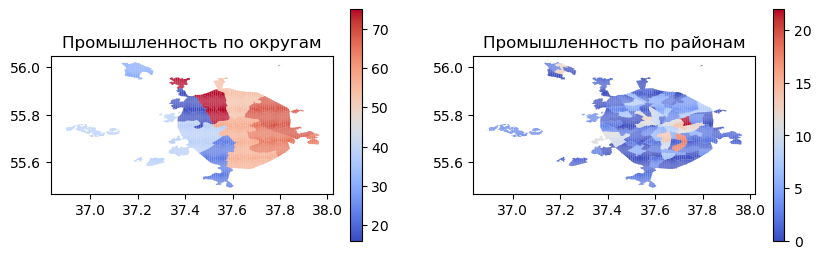

In [11]:
df = preprocess(business_promishlennost, "Район")
gdf_n = transform(df, gdf)
plot_show(gdf_n, "Промышленность")

### Вышки связи и городской вай-фай ###

In [12]:
connection_basestations = pd.read_excel(r"..\data\data-mos-ru\data-connection-basestations.xlsx", skiprows=1)
connection_basestations = connection_basestations[["Тип объекта ", "Административный округ", 
                                                   "Район", "Местоположение", "Долгота в WGS-84", "Широта в WGS-84", 
                                                   "Сведения о базовых станциях на объекте"]]

connection_citywifi = pd.read_excel(r"..\data\data-mos-ru\data-connections-citywifi.xlsx", skiprows=1)
connection_citywifi = connection_citywifi[["Наименование", "Административный округ", "Район", "Месторасположение", 
                                           "Количество точек доступа", "Зона покрытия (метры)", "Признак функционирования",
                                           "Условия доступа", "Широта в WGS-84", "Долгота в WGS-84", "geodata_center"]]

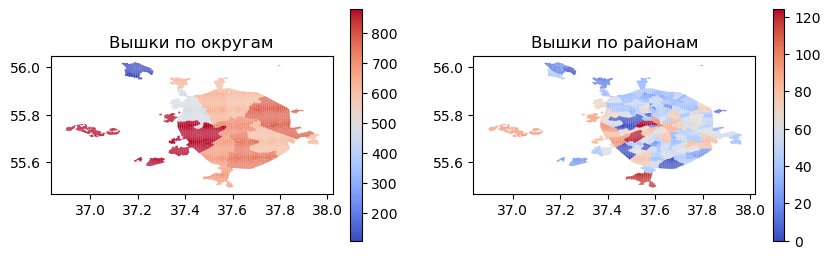

In [13]:
df = preprocess(connection_basestations, "Район")
gdf_n = transform(df, gdf)
plot_show(gdf_n, "Вышки")

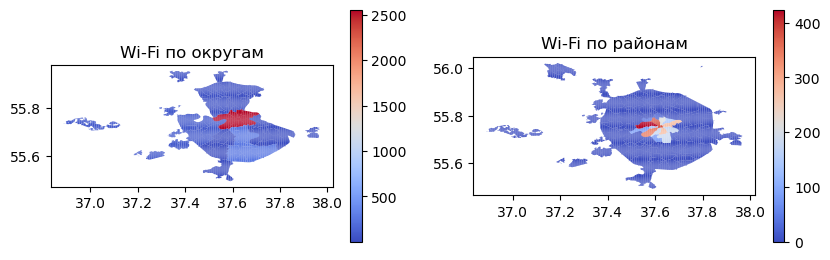

In [14]:
df = preprocess(connection_citywifi, "Район")
gdf_n = transform(df, gdf)
plot_show(gdf_n, "Wi-Fi")

### Досуг ###

In [15]:
dosug_kidsplaygounds = pd.read_excel(r"..\data\data-mos-ru\data-dosug-kidsplaygounds.xlsx", skiprows=1)
dosug_kidsplaygounds = dosug_kidsplaygounds[["Административный округ", "Район", "geodata_center"]]

dosug_opensportsquares = pd.read_excel(r"..\data\data-mos-ru\data-dosug-opensportcomplex.xlsx", skiprows=1)
dosug_opensportsquares = dosug_opensportsquares[["Административный округ", "Район", "Адрес", 
                                                 "Форма посещения (платность)"]]

dosug_kidsparks = pd.read_excel(r"..\data\data-mos-ru\data-dosug-parks.xlsx", skiprows=1)
dosug_kidsparks = dosug_kidsparks[["Административный округ", "Район", "Адрес", "Форма посещения (платность)"]]

dosug_skateparks = pd.read_excel(r"..\data\data-mos-ru\data-dosug-skateparks.xlsx", skiprows=1)
dosug_skateparks = dosug_skateparks[["Административный округ", "Район", "Адрес"]]

dosug_fitness = pd.read_excel(r"..\data\data-mos-ru\data-dosug-sportcomplex.xlsx", skiprows=1)
dosug_fitness = dosug_fitness[["Административный округ", "Район", "Адрес", "Форма посещения (платность)"]]

dosug_sportrooms = pd.read_excel(r"..\data\data-mos-ru\data-dosug-sportrooms.xlsx", skiprows=1)
dosug_sportrooms = dosug_sportrooms[["Административный округ", "Район", "Адрес", "Форма посещения (платность)"]]

sports_sportcomplexes = pd.read_excel(r"..\data\data-mos-ru\data-sports-sportobjects.xlsx", skiprows=1)
sports_sportcomplexes = sports_sportcomplexes[["Категория", "Услуги", "geodata_center"]]

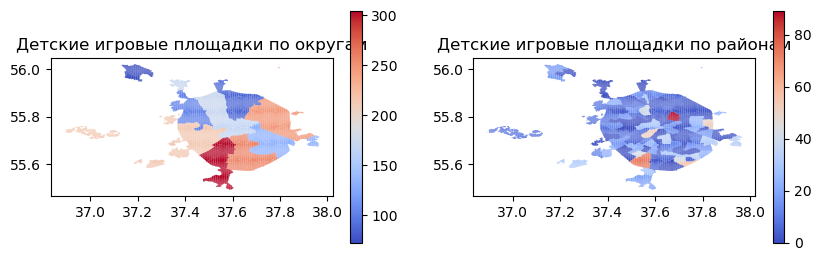

In [16]:
df = preprocess(dosug_kidsplaygounds, "Район")
gdf_n = transform(df, gdf)
plot_show(gdf_n, "Детские игровые площадки")

all_dosug_kids = pd.concat([gdf_n])

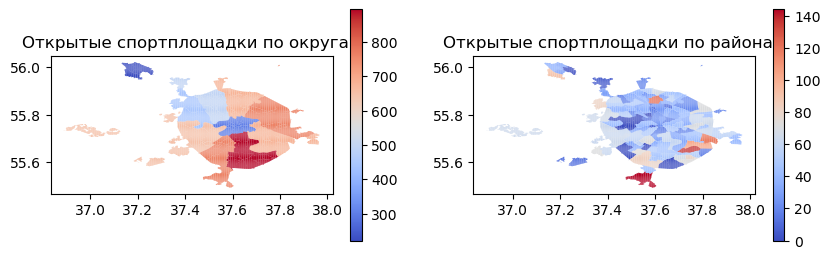

In [17]:
df = preprocess(dosug_opensportsquares, "Район")
gdf_n = transform(df, gdf)
plot_show(gdf_n, "Открытые спортплощадки")

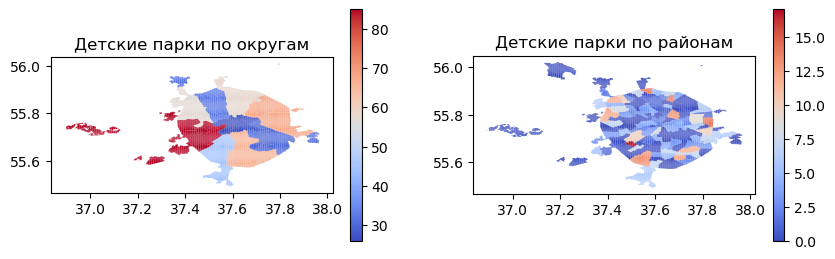

In [18]:
df = preprocess(dosug_kidsparks, "Район")
gdf_n = transform(df, gdf)
plot_show(gdf_n, "Детские парки")

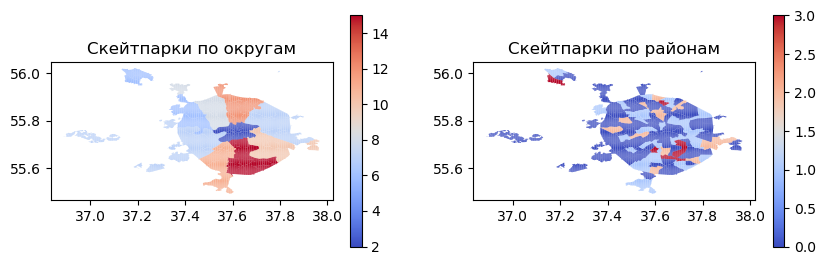

In [19]:
df = preprocess(dosug_skateparks, "Район")
gdf_n = transform(df, gdf)
plot_show(gdf_n, "Скейтпарки")

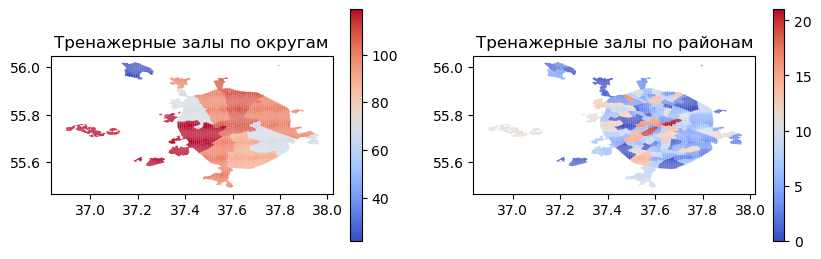

In [20]:
df = preprocess(dosug_fitness, "Район")
gdf_n = transform(df, gdf)
plot_show(gdf_n, "Тренажерные залы")

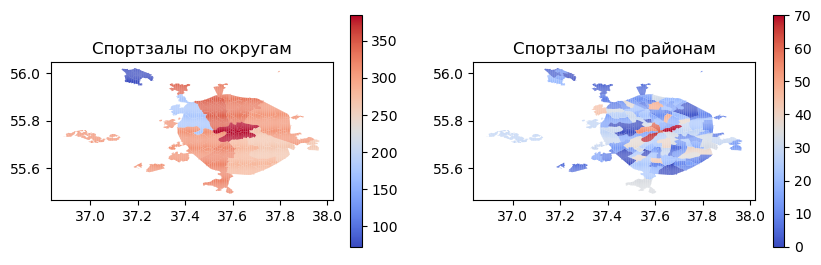

In [21]:
df = preprocess(dosug_sportrooms, "Район")
gdf_n = transform(df, gdf)
plot_show(gdf_n, "Спортзалы")

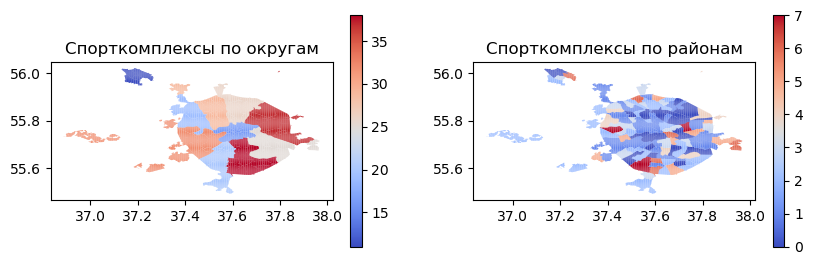

In [24]:
gdf_n = transform_from_geocenter(sports_sportcomplexes, gdf)
plot_show(gdf_n, "Спорткомплексы")

### точки питания ###

In [27]:
eat_commoneat = pd.read_excel(r"..\data\data-mos-ru\data-eat-commoneat.xlsx", skiprows=1)
eat_commoneat = eat_commoneat[["Является сетевым", "Вид объекта", "Административный округ по адресу", "Район", 
                              "Адрес", "Число посадочных мест", "Долгота в WGS-84", "Широта в WGS-84"]]
eat_commoneat.rename(columns={"Административный округ по адресу": "Административный округ"}, inplace=True)

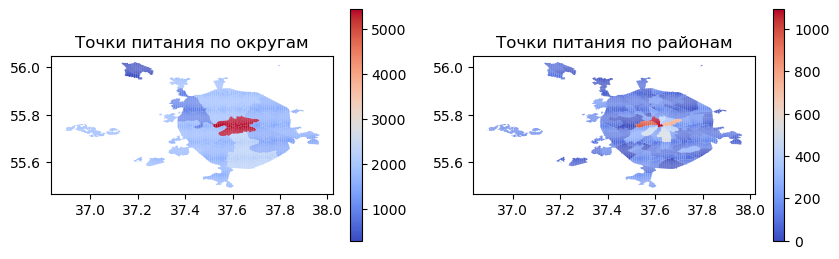

In [28]:
df = preprocess(eat_commoneat, "Район")
gdf_n = transform(df, gdf)
plot_show(gdf_n, "Точки питания")

In [29]:
# сводная таблица, посмотреть грануляцию по разным видам точек питания
pd.pivot_table(eat_commoneat, 
               values="Район", 
               columns="Вид объекта", 
               index="Административный округ", 
               aggfunc="count",
               margins=True).sort_values(by="All", ascending=False)

Вид объекта,бар,буфет,закусочная,кафе,кафетерий,магазин (отдел кулинарии),предприятие быстрого обслуживания,ресторан,столовая,All
Административный округ,,,,,,,,,,
All,1331,443,626,7300,1623,474,3307,2411,2217,19732
Центральный административный округ,666,109,92,2368,368,84,390,1047,314,5438
Южный административный округ,118,29,55,701,183,48,569,214,311,2228
Северный административный округ,80,61,70,674,242,36,241,210,204,1818
Северо-Восточный административный округ,75,21,65,612,176,50,415,113,289,1816
Западный административный округ,60,86,58,609,122,23,285,260,209,1712
Юго-Западный административный округ,69,26,45,561,130,41,346,141,233,1592
Восточный административный округ,85,40,50,444,138,74,386,98,232,1547
Юго-Восточный административный округ,56,35,108,521,69,28,307,123,159,1406


### образование ###

In [30]:
# в датасетах не содержится ВУЗОВ
edu_gosedu = pd.read_excel(r"..\data\data-mos-ru\data-edu-gosedu.xlsx", skiprows=1)
edu_gosedu = edu_gosedu[["Статус организации", "Юридический адрес", "geodata_center"]]

edu_dopeducation = pd.read_excel(r"..\data\data-mos-ru\data-edu-dopeducation.xlsx", skiprows=1)
edu_dopeducation = edu_dopeducation[["Административный округ по адресу", "Район", "Юридический адрес"]]
edu_dopeducation.rename(columns={"Административный округ по адресу": "Административный округ"}, inplace=True)

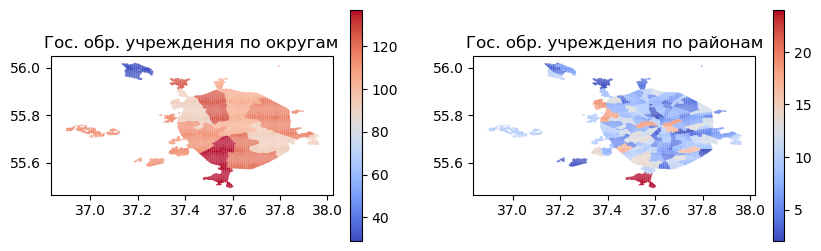

In [31]:
gdf_n = transform_from_geocenter(edu_gosedu, gdf)
plot_show(gdf_n, "Гос. обр. учреждения")

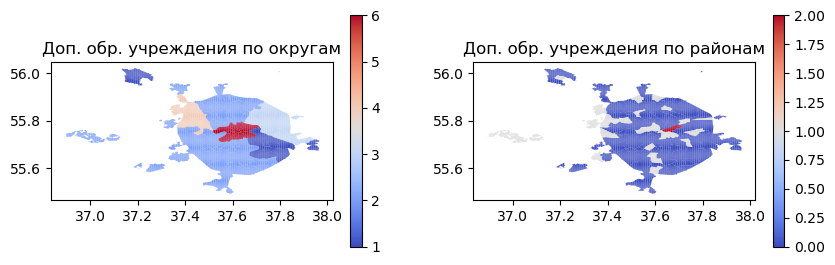

In [32]:
df = preprocess(edu_dopeducation, "Район")
gdf_n = transform(df, gdf)
plot_show(gdf_n, "Доп. обр. учреждения")

### Количество отелей ###

In [33]:
masterdata_hostels = pd.read_excel(r"..\data\data-mos-ru\data-masterdata-hostels.xlsx", skiprows=1)
masterdata_hostels = masterdata_hostels[["Административный округ", "Район", "Фактический адрес", "Присвоенная категория"]]

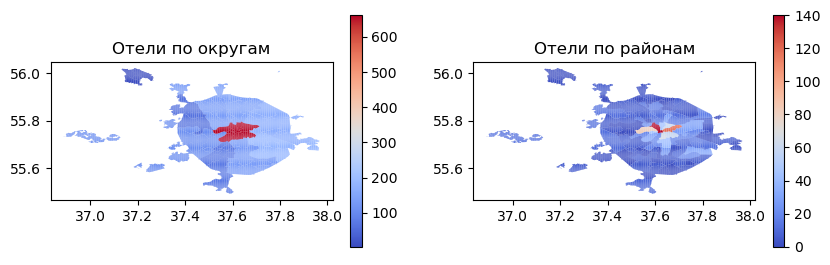

In [53]:
df = preprocess(masterdata_hostels, "Район")
gdf_n = transform(df, gdf)
plot_show(gdf_n, "Отели")

In [35]:
# чистка номеров :)

masterdata_hostels["Присвоенная категория"] = masterdata_hostels["Присвоенная категория"].str.lower()
masterdata_hostels["Присвоенная категория"] = masterdata_hostels["Присвоенная категория"].str.replace("ё", "e")
masterdata_hostels["Присвоенная категория"] = masterdata_hostels["Присвоенная категория"].str.replace("xtnsht pdtpls", "четыре")
masterdata_hostels["Присвоенная категория"] = masterdata_hostels["Присвоенная категория"].str.replace(",tp pdtpl", "без")
masterdata_hostels["Присвоенная категория"] = masterdata_hostels["Присвоенная категория"].str.replace("4", "четыре")
masterdata_hostels["Присвоенная категория"] = masterdata_hostels["Присвоенная категория"].str.replace("звезжы", "")
masterdata_hostels["Присвоенная категория"] = masterdata_hostels["Присвоенная категория"].str.replace("бехз", "без")
masterdata_hostels["Присвоенная категория"] = masterdata_hostels["Присвоенная категория"].str.replace("звезд[аы]?", "", regex=True)
masterdata_hostels["Присвоенная категория"] = masterdata_hostels["Присвоенная категория"].str.replace("(звeзд|заезд|завезд)", "", regex=True)
masterdata_hostels["Присвоенная категория"] = masterdata_hostels["Присвоенная категория"].str.replace(r"\s+", " ", regex=True)
masterdata_hostels["Присвоенная категория"] = masterdata_hostels["Присвоенная категория"].str.replace(r"^[ \s]+|[ \s]+$", "", regex=True)

In [36]:
# посмотрим распределение по звездам

pd.pivot_table(masterdata_hostels, 
               values="Район", 
               columns="Присвоенная категория", 
               index="Административный округ", 
               aggfunc="count",
               margins=True).sort_values(by="All", ascending=False)

Присвоенная категория,без,две,одна,пять,три,четыре,All
Административный округ,,,,,,,
All,470.0,67.0,45.0,24.0,173.0,72.0,851
Центральный административный округ,115.0,27.0,22.0,21.0,87.0,45.0,317
Северо-Восточный административный округ,58.0,9.0,NaN,NaN,18.0,2.0,87
Восточный административный округ,63.0,8.0,3.0,NaN,7.0,3.0,84
Северный административный округ,48.0,1.0,3.0,2.0,12.0,4.0,70
Юго-Восточный административный округ,41.0,8.0,2.0,1.0,14.0,3.0,69
Южный административный округ,44.0,5.0,5.0,NaN,8.0,3.0,65
Западный административный округ,40.0,2.0,4.0,NaN,11.0,1.0,58
Юго-Западный административный округ,23.0,4.0,5.0,NaN,7.0,2.0,41


### медицина ###

In [37]:
med_adult = pd.read_excel(r"..\data\data-mos-ru\data-med-adult.xlsx", skiprows=1)
med_adult = med_adult[["Категория", "Адреса объекта", "Признак закрытия", "Коечный фонд", "Информация о платных услугах", 
                      "Наличие аптечного киоска", "Наличие станции неотложной помощи", "geodata_center"]]

med_adult_policlinic = pd.read_excel(r"..\data\data-mos-ru\data-med-adult-policlinic.xlsx", skiprows=1)
med_adult_policlinic = med_adult_policlinic[["Категория", "Адреса объекта", "Признак закрытия", 
                                           "Информация о платных услугах", "Наличие аптечного киоска", 
                                           "Наличие станции неотложной помощи", "geodata_center"]]

med_drugstores = pd.read_excel(r"..\data\data-mos-ru\data-med-drugstores.xlsx", skiprows=1)
med_drugstores = med_drugstores[["Административный округ", "Район", "Адрес", "geodata_center"]]

med_kids = pd.read_excel(r"..\data\data-mos-ru\data-med-kids.xlsx", skiprows=1)
med_kids = med_kids[["Категория", "Адреса объекта", "Признак закрытия", "Коечный фонд", "Наличие аптечного киоска",
                     "Информация о платных услугах", "Наличие станции неотложной помощи", "geodata_center"]]

med_kids_policlinic = pd.read_excel(r"..\data\data-mos-ru\data-med-kids-policlinic.xlsx", skiprows=1)
med_kids_policlinic = med_kids_policlinic[["Категория", "Адреса объекта", "Признак закрытия", 
                                           "Информация о платных услугах", "Наличие аптечного киоска", 
                                           "Наличие станции неотложной помощи", "geodata_center"]]

In [38]:
# нужна отдельная функция для чистки мед. фреймов, т.к. адреса приходится выдирать регуляркой

def preprocess_med(df):
    df = df.join(df["Адреса объекта"].str.split("\n", expand=True)[[0,1]])
    df.rename(columns={0: "Административный округ", 1: "Район"}, inplace=True)

    df["Административный округ"] = df["Административный округ"].str.replace("AdmArea:", "")
    df["Административный округ"] = df["Административный округ"].str.replace(r"^[ \s]+|[ \s]+$", "", regex=True)

    df["Район"] = df["Район"].str.replace("District:", "")
    df["Район"] = df["Район"].str.replace(r"^[ \s]+|[ \s]+$", "", regex=True)
    
    return df

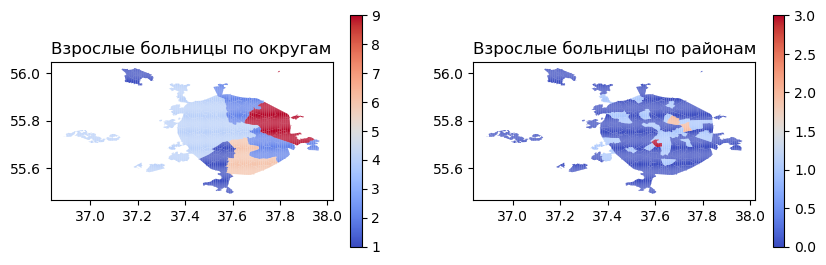

In [39]:
df = preprocess_med(med_adult)
df = preprocess(df, "Район")
gdf_n = transform(df, gdf)
plot_show(gdf_n, "Взрослые больницы")

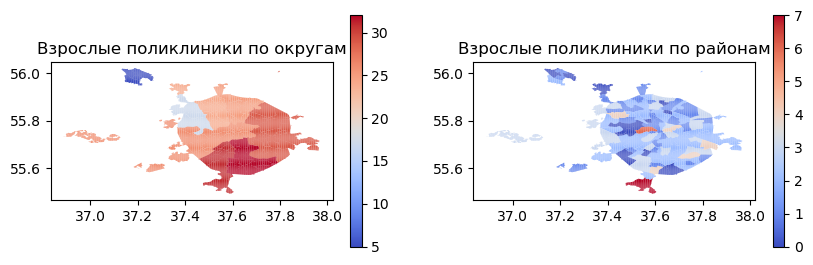

In [40]:
df = preprocess_med(med_adult_policlinic)
df = preprocess(df, "Район")
gdf_n = transform(df, gdf)
plot_show(gdf_n, "Взрослые поликлиники")

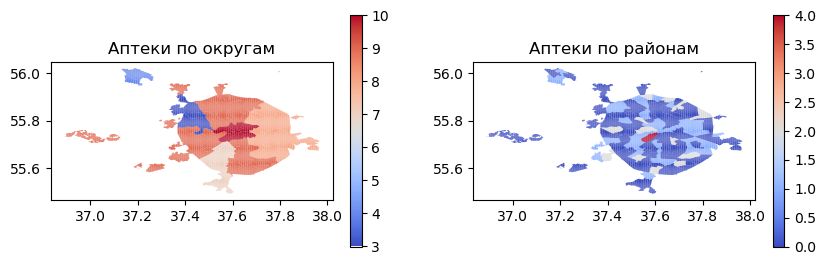

In [41]:
df = preprocess(med_drugstores, "Район")
gdf_n = transform(df, gdf)
plot_show(gdf_n, "Аптеки")

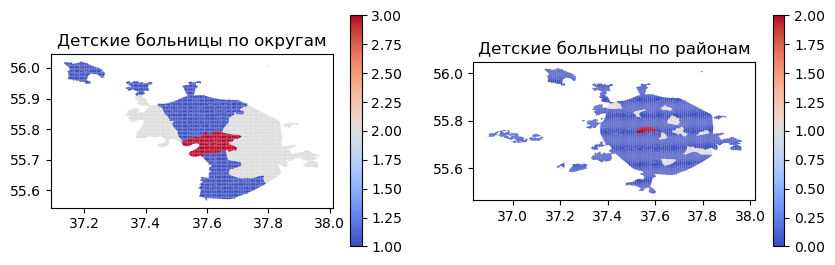

In [42]:
df = preprocess_med(med_kids)
df = preprocess(df, "Район")
gdf_n = transform(df, gdf)
plot_show(gdf_n, "Детские больницы")

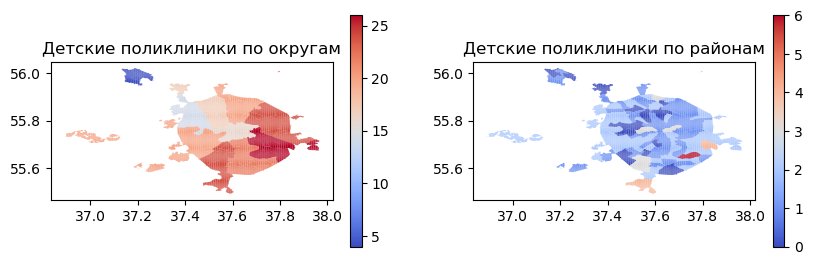

In [43]:
df = preprocess_med(med_kids_policlinic)
df = preprocess(df, "Район")
gdf_n = transform(df, gdf)
plot_show(gdf_n, "Детские поликлиники")

### Расположение метро ###

In [44]:
metro_geo = pd.read_excel(r"..\data\data-mos-ru\data-metro-geo.xlsx", skiprows=1)
metro_geo = metro_geo[["Административный округ", "Район", "Долгота в WGS-84", "Широта в WGS-84", "Станция метрополитена",
                       "Линия", "Статус объекта", "geodata_center"]]

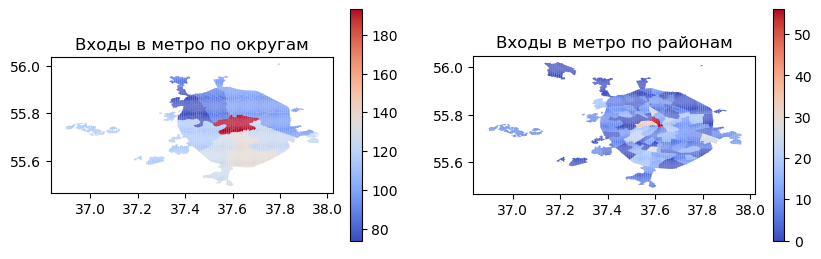

In [45]:
df = preprocess(metro_geo, "Район")
gdf_n = transform(df, gdf)
plot_show(gdf_n, "Входы в метро")

### Нежилые помещения ###

In [47]:
property_notlivinghouses = pd.read_excel(r"..\data\data-mos-ru\data-property-notlivinghouses.xlsx", skiprows=1)
property_notlivinghouses = property_notlivinghouses[["Административный округ", "Район", "Адрес", "Площадь (кв.м.)",
                                                    "Год постройки", "Вид объекта (здание, помещение)", 
                                                    "Назначение строения по БТИ", "Класс постройки (жилое / нежилое)",
                                                    "geodata_center"]]

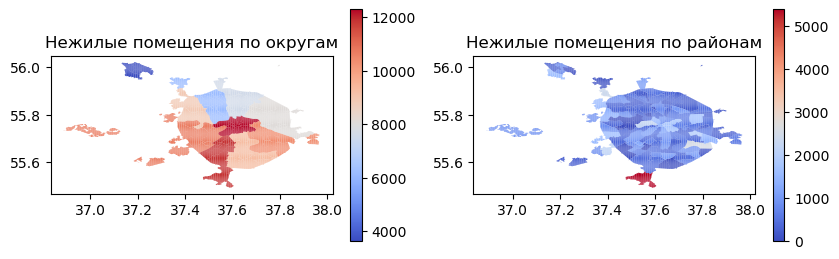

In [48]:
df = preprocess(property_notlivinghouses, "Район")
gdf_n = transform(df, gdf)
plot_show(gdf_n, "Нежилые помещения")

In [49]:
# посмотрим распределение жилых и нежилых помещений

pd.pivot_table(property_notlivinghouses, 
               values="Район", 
               columns="Класс постройки (жилое / нежилое)", 
               index="Административный округ", 
               aggfunc="count",
               margins=True).sort_values(by="All", ascending=False)

Класс постройки (жилое / нежилое),жилые,нежилые,неопределённые,All
Административный округ,,,,
All,36106.0,53210.0,77.0,89393
Центральный административный округ,5914.0,6378.0,1.0,12293
Юго-Западный административный округ,4457.0,7431.0,NaN,11888
Западный административный округ,4437.0,6242.0,NaN,10679
Юго-Восточный административный округ,2573.0,7466.0,NaN,10039
Южный административный округ,3684.0,5599.0,NaN,9283
Северо-Западный административный округ,3715.0,5183.0,NaN,8898
Восточный административный округ,3718.0,4354.0,NaN,8072
Северо-Восточный административный округ,2953.0,4635.0,NaN,7588


### Предоставление услуг и торговля товарами ###

In [50]:
trade_bitovieuslugi = pd.read_excel(r"..\data\data-mos-ru\data-trade-bitovieuslugi.xlsx", skiprows=1)
trade_bitovieuslugi = trade_bitovieuslugi[["Вид объекта бытового обслуживания", "Является сетевым", "Вид услуги", 
                                           "Административный округ", "Район", "Широта в WGS-84", "Долгота в WGS-84"]]

trade_stacionarnietochki = pd.read_excel(r"..\data\data-mos-ru\data-trade-stacionarnietochki.xlsx", skiprows=1)
trade_stacionarnietochki = trade_stacionarnietochki[["Вид услуги", "Вид объекта", "Является сетевым", 
                                                    "Административный округ", "Район", "geodata_center"]]

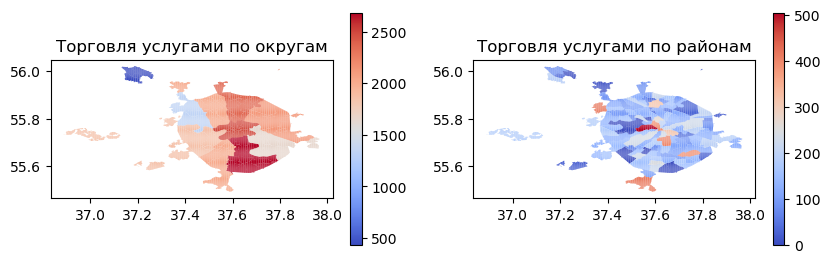

In [51]:
df = preprocess(trade_bitovieuslugi, "Район")
gdf_n = transform(df, gdf)
plot_show(gdf_n, "Торговля услугами")

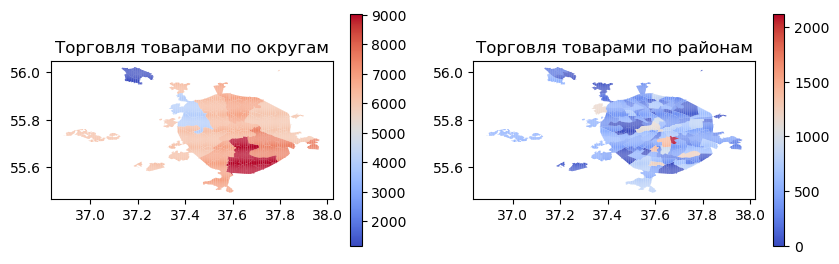

In [52]:
df = preprocess(trade_stacionarnietochki, "Район")
gdf_n = transform(df, gdf)
plot_show(gdf_n, "Торговля товарами")